In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import tensorflow as tf
from tensorflow import keras
from keras import layers
import gc
import os, cv2
 
from PIL import Image 
import warnings
warnings.filterwarnings('ignore')

C:\Users\Irakli\AppData\Local\Temp\ipykernel_3304\2869429275.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
path = 'lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

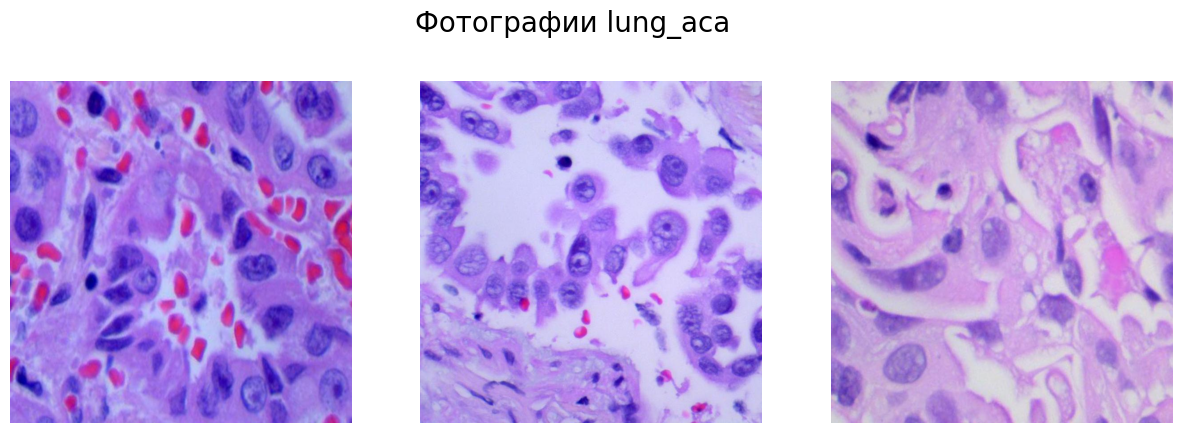

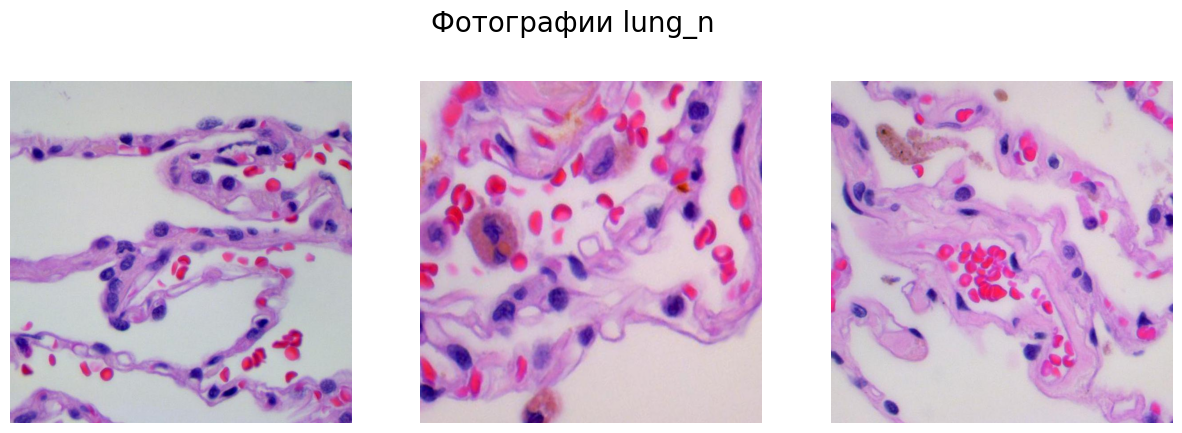

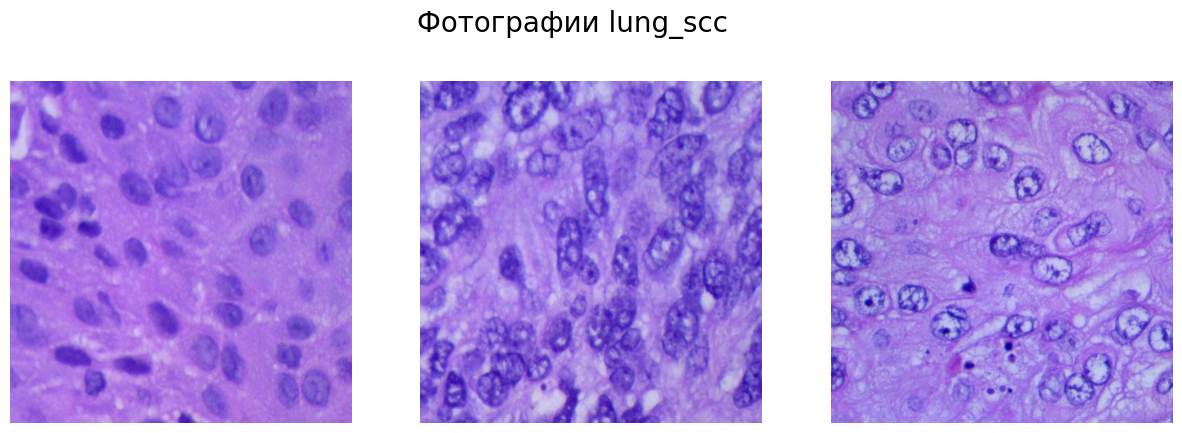

In [3]:
path = 'lung_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Фотографии {cat}', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [ ]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [4]:
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [6]:
model_cnn = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							3),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(3, activation='softmax')
])


In [7]:
model_cnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [8]:
history = model_cnn.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.8069 - loss: 0.4886 - val_accuracy: 0.6390 - val_loss: 1.8744 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9156 - loss: 0.2238 - val_accuracy: 0.6253 - val_loss: 1.6865 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9253 - loss: 0.1830 - val_accuracy: 0.3307 - val_loss: 6.0722 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9484 - loss: 0.1372
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9483 - loss: 0.1373 - val_accuracy: 0.4313 - val_loss: 4.9925 - learning_rate: 0.0010


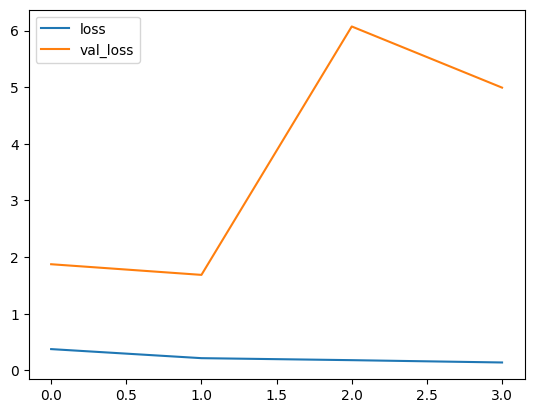

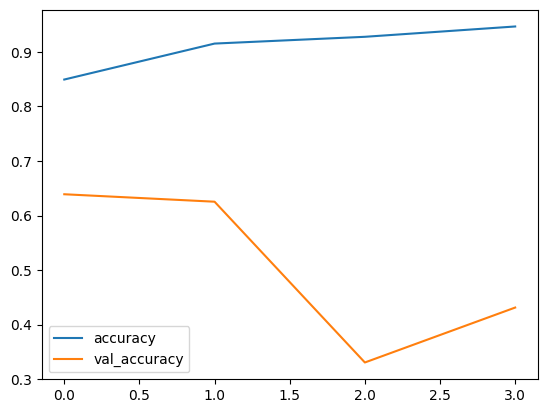

In [9]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [10]:
Y_pred = model_cnn.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step


In [11]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.48      1.00      0.65       987
      lung_n       1.00      0.93      0.96       977
    lung_scc       1.00      0.02      0.05      1036

    accuracy                           0.64      3000
   macro avg       0.82      0.65      0.55      3000
weighted avg       0.83      0.64      0.54      3000

